In [1]:
import pywt
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
cA, cD = pywt.dwt([1, 2, 3, 4], 'db1')

In [3]:
cD

array([-0.70710678, -0.70710678])

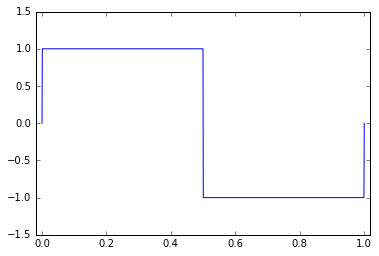

In [4]:
w = pywt.Wavelet('Haar')
phi, psi, x = w.wavefun(level=10)

fig, ax = plt.subplots()
ax.set_xlim(-.02,1.02)
ax.plot(x, psi);


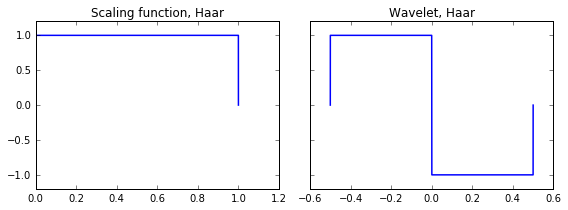

In [16]:
db8 = pywt.Wavelet('haar')
scaling, wavelet, x = db8.wavefun(level=12)

fig, axes = plt.subplots(1, 2, sharey=True, figsize=(8,3))
ax1, ax2 = axes

ax1.plot(x, scaling,linewidth=1.5);
ax1.set_title('Scaling function, Haar');
ax1.set_ylim(-1.2, 1.2);

ax2.set_title('Wavelet, Haar');
ax2.tick_params(labelleft=False);
ax2.plot(x-x.mean(), wavelet,linewidth=1.5);

fig.tight_layout()

# figfile='Haar_wavelet.png'
# plt.savefig(figfile,format='png',dpi=300)

In [6]:
def doppler(x):
    """
    Parameters
    ----------
    x : array-like
        Domain of x is in (0,1]
 
    """
    if not np.all((x >= 0) & (x <= 1)):
        raise ValueError("Domain of doppler is x in (0,1]")
    return np.sqrt(x*(1-x))*np.sin((2.1*np.pi)/(x+.05))
 
def blocks(x):
    """
    Piecewise constant function with jumps at t.
 
    Constant scaler is not present in Donoho and Johnstone.
    """
    K = lambda x : (1 + np.sign(x))/2.
    t = np.array([[.1, .13, .15, .23, .25, .4, .44, .65, .76, .78, .81]]).T
    h = np.array([[4, -5, 3, -4, 5, -4.2, 2.1, 4.3, -3.1, 2.1, -4.2]]).T
    return 3.655606 * np.sum(h*K(x-t), axis=0)
 
def bumps(x):
    """
    A sum of bumps with locations t at the same places as jumps in blocks.
    The heights h and widths s vary and the individual bumps are of the
    form K(t) = 1/(1+|x|)**4
    """
    K = lambda x : (1. + np.abs(x)) ** -4.
    t = np.array([[.1, .13, .15, .23, .25, .4, .44, .65, .76, .78, .81]]).T
    h = np.array([[4, 5, 3, 4, 5, 4.2, 2.1, 4.3, 3.1, 2.1, 4.2]]).T
    w = np.array([[.005, .005, .006, .01, .01, .03, .01, .01, .005, .008, .005]]).T
    return np.sum(h*K((x-t)/w), axis=0)
 
def heavisine(x):
    """
    Sinusoid of period 1 with two jumps at t = .3 and .72
    """
    return 4 * np.sin(4*np.pi*x) - np.sign(x - .3) - np.sign(.72 - x)

In [7]:
x = np.linspace(0,1,2**11)
dop = doppler(x)
blk = blocks(x)
bmp = bumps(x)
hsin = heavisine(x)

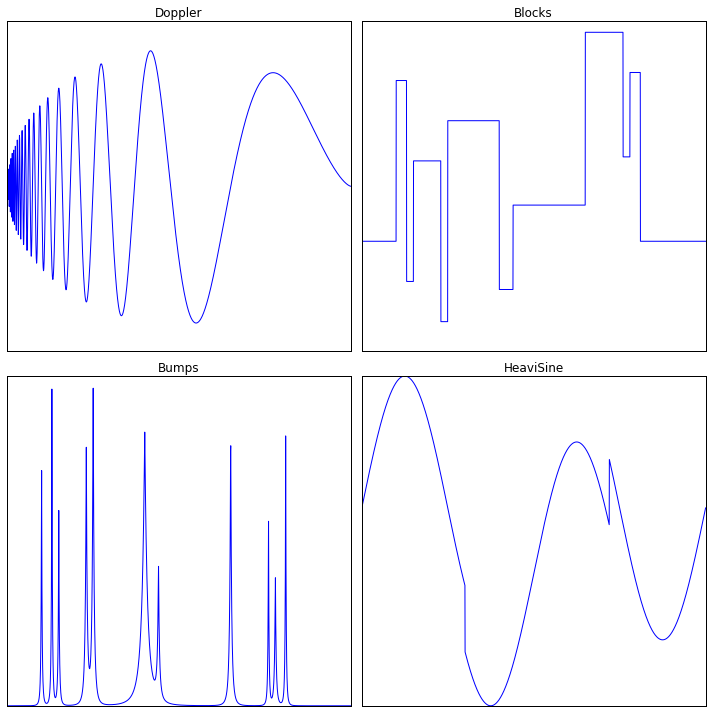

In [8]:

fig, axes = plt.subplots(2, 2, figsize=(10,10))
ax1 = axes[0,0]
ax2 = axes[0,1]
ax3 = axes[1,0]
ax4 = axes[1,1]

ax1.plot(x,dop)
ax1.set_title("Doppler")

ax2.plot(x,blk)
ax2.set_title("Blocks")

ax3.plot(x,bmp)
ax3.set_title("Bumps")

ax4.set_title("HeaviSine")
ax4.plot(x,hsin)

for ax in fig.axes:
    ax.tick_params(labelbottom=False, labelleft=False, bottom=False, 
                   top=False, left=False, right=False)

fig.tight_layout();

In [9]:
from math import log

def coef_pyramid_plot(coefs, first=0, scale='uniform',amplify=1, ax=None):
    """
    Parameters
    ----------
    coefs : array-like
        Wavelet Coefficients. Expects an iterable in order Cdn, Cdn-1, ...,
        Cd1, Cd0.
    first : int, optional
        The first level to plot.
    scale : str {'uniform', 'level'}, optional
        Scale the coefficients using the same scale or independently by
        level.
    ax : Axes, optional
        Matplotlib Axes instance

    Returns
    -------
    Figure : Matplotlib figure instance
        Either the parent figure of `ax` or a new pyplot.Figure instance if
        `ax` is None.
    """

    if ax is None:
        import matplotlib.pyplot as plt
        fig = plt.figure()
        ax = fig.add_subplot(111, axisbg='lightgrey')
    else:
        fig = ax.figure

    n_levels = len(coefs)
#     print(n_levels)
    n = 2**(n_levels - 1) # assumes periodic

    if scale == 'uniform':
        biggest = [np.max(np.abs(np.hstack(coefs)))] * n_levels
    else:
        # multiply by 2 so the highest bars only take up .5
        biggest = [np.max(np.abs(i))*2 for i in coefs]

    for i in range(first,n_levels):
        x = np.linspace(2**(n_levels - 2 - i), n - 2**(n_levels - 2 - i),  2**(int(log(len(coefs[i]),2))))
        ymin = n_levels - i - 1 + first
        yheight = coefs[i]/biggest[i]*amplify
        #print('*',yheight,biggest[i])
#         print('*',ymin)
        ymax = yheight + ymin
#         print('*',np.max(np.abs(ymax-ymin)))
        ax.vlines(x, [ymin], ymax, linewidth=1.1)
#         print(len(x),len(coefs[i]))

    ax.set_xlim(0,n)
    ax.set_ylim(first - 1, n_levels)
    ax.yaxis.set_ticks(np.arange(n_levels-1,first-1,-1))
    ax.yaxis.set_ticklabels(np.arange(first,n_levels))
    ax.tick_params(top=False, right=False, direction='out', pad=6)
    ax.set_ylabel("Levels", fontsize=14)
    ax.grid(True, alpha=.85, color='grey', axis='y', linestyle='--')
    ax.set_title('Wavelet Detail Coefficients', fontsize=16,
            position=(.5,1.05))
    fig.subplots_adjust(top=.89)

    return fig

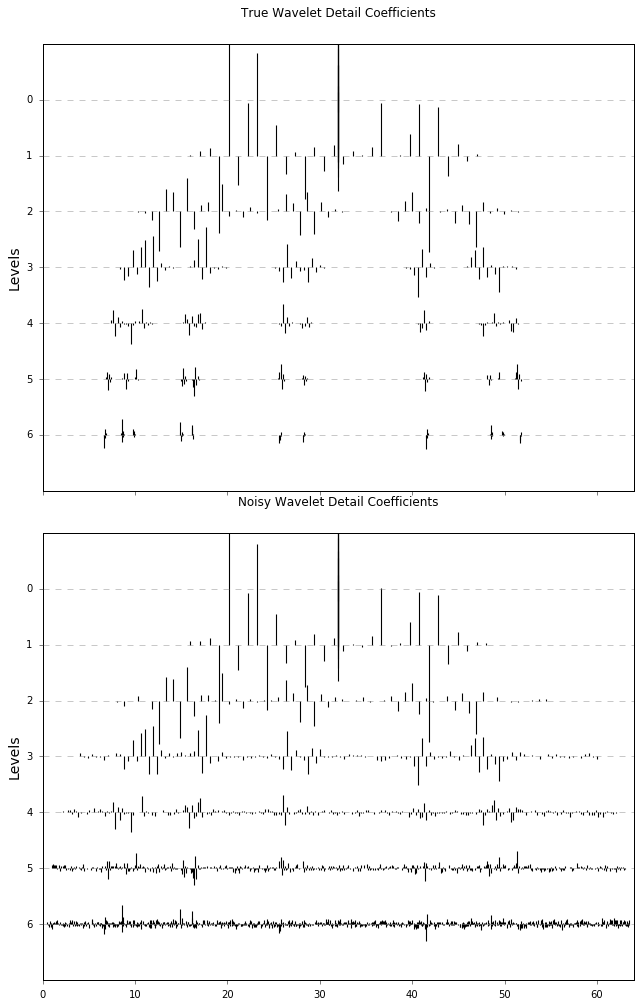

In [10]:
from scipy import stats
import numpy as np

np.random.seed(12345)
blck = blocks(np.linspace(0,1,2**11+10))
nblck = blck + np.random.randn(len(blck))#stats.norm().rvs(2**11)

true_coefs = pywt.wavedec(blck, 'db8', level=7, mode='per')
noisy_coefs = pywt.wavedec(nblck, 'db8', level=7, mode='per')

fig, axes = plt.subplots(2, 1, figsize=(9,14), sharex=True)
# fig = plt.figure()
# ax = fig.add_subplot(111, axisbg='lightgrey')

fig = coef_pyramid_plot(true_coefs[1:], scale='uniform',amplify=2,ax=axes[0]) # omit smoothing coefs
axes[0].set_title("True Wavelet Detail Coefficients");


fig = coef_pyramid_plot(noisy_coefs[1:],scale='uniform',amplify=2, ax=axes[1]) ;
axes[1].set_title("Noisy Wavelet Detail Coefficients");


fig.tight_layout()

In [11]:
from statsmodels.robust import stand_mad

sigma = stand_mad(noisy_coefs[-1])
uthresh = sigma*np.sqrt(2*np.log(len(nblck)))

denoised = noisy_coefs[:]

denoised[1:] = (pywt.threshold(i, value=uthresh,mode='soft') for i in denoised[1:])

C:\Users\JLi104\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\robust\scale.py:49: FutureWarning: stand_mad is deprecated and will be removed in 0.7.0. Use mad instead.
  "instead.", FutureWarning)


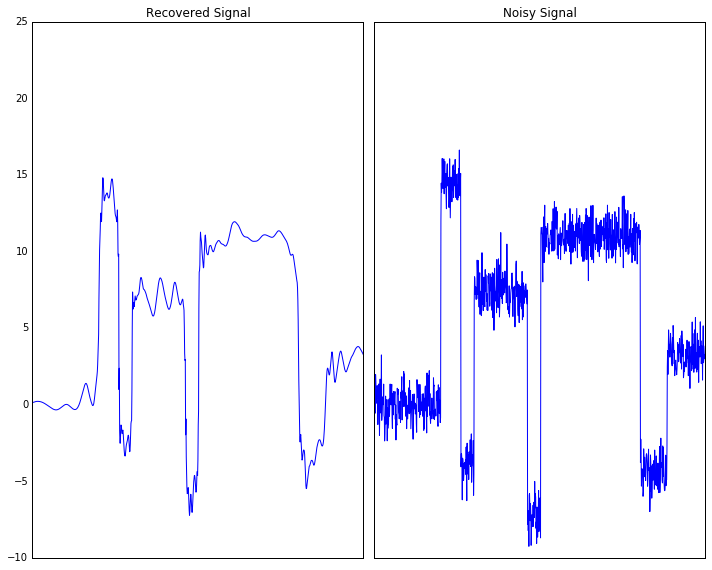

In [12]:
signal = pywt.waverec(denoised, 'db8', mode='per')

fig, axes = plt.subplots(1, 2, sharey=True, sharex=True,
                         figsize=(10,8))
ax1, ax2 = axes

ax1.plot(signal)
ax1.set_xlim(0,2**10)
ax1.set_title("Recovered Signal")
ax1.margins(.1)

ax2.plot(nblck)
ax2.set_title("Noisy Signal")

for ax in fig.axes:
    ax.tick_params(labelbottom=False, top=False, bottom=False, left=False, 
                 right=False)
    
fig.tight_layout()